In [2]:
# Modèle 3 : LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance

import warnings
warnings.filterwarnings('ignore')

import os
import time
import random
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping


###### package courant pour le machine learning ######

import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)

# # theano
# import theano
# print('theano: %s' % theano.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# keras
import keras
print('keras: %s' % keras.__version__)

def read(file_name):
    xl = 0
    try:
        df = pd.read_excel(f"data/{file_name}.xlsx")
        xl = 1
    except:
        df = pd.read_csv(f"data/{file_name}.csv", sep='|', encoding='utf-8', on_bad_lines='skip')
        xl = 0

    df.columns = df.columns.str.lower()
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        if xl:
            df['year'] = df['date'].dt.year
    return df

scipy: 1.15.3
numpy: 2.3.1
matplotlib: 3.10.3
pandas: 2.3.0
statsmodels: 0.14.4
sklearn: 1.7.0
tensorflow: 2.20.0
keras: 3.10.0


In [3]:
data = pd.read_csv('data/df.csv',sep='|')
data['date'] = pd.to_datetime(data['date'])

#plt.figure(figsize=(12, 6))
#plt.plot(ts)
#plt.title('Prix journaliers du S&P500')
#plt.show()

DXY = yfinance.download('DX-Y.NYB', start='1999-01-04', end='2025-09-19')
DXY = DXY.reset_index()[['Date','Close']]
DXY.columns = ['date','DXY']
data=data.merge(DXY, on='date', how='left')

GDPM = pd.read_csv('GDP Monthly.csv',sep=',')
GDPM['date'] = pd.to_datetime(GDPM['timestamp'])
GDPM['year'] = GDPM['date'].dt.year
GDPM['month'] = GDPM['date'].dt.month
GDPM['CroissM'] = GDPM['EIA/GDPQXUS/USA'].diff()

# GDPQ = pd.read_csv('GDP Quarter.csv',sep=',')
# GDPQ['date'] = pd.to_datetime(GDPQ['timestamp'])
# GDPQ['year'] = GDPQ['date'].dt.year
# GDPQ['month'] = GDPQ['date'].dt.month

# GDPQ_full = []
# for _, row in GDPQ.iterrows():
#     for m in range(row['date'].quarter * 3 - 2, row['date'].quarter * 3 + 1):
#         GDPQ_full.append({'year': row['year'], 'month': m, 'CroissQ': row['CroissQ']})
# GDPQ_full = pd.DataFrame(GDPQ_full)


data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

data = data.merge(GDPM, on=['year', 'month'], how='left')
#data = data.merge(GDPQ, on=['year', 'month'], how='left')
#data.drop(['timestamp_x','date_y','timestamp_y', 'date'], axis=1, inplace=True)
data.drop(['timestamp','date_y','year','month'], axis=1, inplace=True)
data['DXY'].fillna(method='ffill', inplace=True)
data.rename(columns = {'date_x': 'date'}, inplace = True)
data.set_index('date', inplace=True)
# data['mid'] = (data['high'] + data['low']) / 2
# data['range'] = data['high'] -data['low']

data['jour_semaine'] = data.index.dayofweek
data['mois'] = data.index.month

data.columns = data.columns.str.lower()

dataa = data.copy()

[*********************100%***********************]  1 of 1 completed


In [90]:
dataa.iloc[-int(len(dataa)*0.1):]

,close,volume,high,low,pe,num_daily_adv_minus_decl,mov_avg_20d,best_eps,dvd_sh_last,rsi_3d,...,close_minus_20d,close_minus_30d,close_minus_50d,close_minus_100d,close_minus_200d,dxy,eia/gdpqxus/usa,croissm,jour_semaine,mois
date,,,,,,,,,,,,,,,,,,,,,
2023-01-17,3990.97,0.975689,4015.39,3984.57,18.9779,-116.0,3873.65,217.3921,0.008982,79.06,...,117.32,83.71,72.05,120.5795,12.80480,102.389999,22403.435,153.976000,1,1
2023-01-18,3928.86,0.969238,4014.16,3926.59,18.6825,-397.0,3877.48,217.2918,0.000000,30.65,...,51.38,26.36,5.76,60.5886,-46.29745,102.360001,22403.435,153.976000,2,1
2023-01-19,3898.85,0.950671,3922.94,3885.54,18.5398,-273.0,3881.54,217.0768,0.488418,21.23,...,17.31,-0.32,-26.81,33.5813,-73.07240,102.059998,22403.435,153.976000,3,1
2023-01-20,3972.61,1.196384,3972.96,3897.86,18.8906,421.0,3889.08,217.2244,0.089214,63.07,...,83.53,72.40,43.63,108.1918,3.73775,102.010002,22403.435,153.976000,4,1
2023-01-23,4019.81,0.888567,4039.31,3971.64,19.1150,286.0,3896.15,217.1708,0.000000,75.54,...,123.66,116.73,87.00,155.4998,53.46430,102.139999,22403.435,153.976000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-12,6584.29,0.914048,6600.21,6579.49,27.4007,-269.0,6472.55,264.7617,0.269140,87.19,...,111.74,146.06,199.40,457.9858,599.36400,97.550003,23785.330,32.422211,4,9
2025-09-15,6615.28,0.881635,6619.62,6602.07,27.5297,-99.0,6480.82,264.8023,1.483275,92.29,...,134.46,164.47,223.67,475.7006,627.12430,97.300003,23785.330,32.422211,0,9
2025-09-16,6606.76,0.978096,6626.99,6600.11,27.4942,-123.0,6488.70,264.8158,0.236378,79.27,...,118.06,146.73,207.62,454.8716,615.50735,96.629997,23785.330,32.422211,1,9


In [6]:
# Fixer la graine pour Python, NumPy, et TensorFlow


seed = int(time.time()) % 2**32  # ou random.randint(0, 2**32 - 1)
# 1759607359
seed = 1759608945
# Fixer le seed
random.seed(seed)
np.random.seed(seed)
tensorflow.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Afficher le seed utilisé
print(f"Seed utilisé pour cette exécution : {seed}")

# (Optionnel) Forcer une exécution déterministe
# Cela peut ralentir l'entraînement, mais rend encore plus reproductible
# os.environ["TF_DETERMINISTIC_OPS"] = "1"


df = dataa.copy()

early_stop = EarlyStopping(
    monitor='val_loss',   # Sur quelle métrique surveiller l'amélioration
    patience=30,          # Nombre d'époques sans amélioration avant arrêt
    verbose=1,            # Affiche un message quand l'arrêt se produit
    restore_best_weights=True  # Restaure les poids correspondant à la meilleure val_loss
)

# Paramètres
seq_len = 30  # Longueur de séquence temporelle

# Normalisation
scaler = MinMaxScaler()
data = scaler.fit_transform(df)

# Création des séquences
X, y = [], []
for i in range(len(data) - seq_len):
    X.append(data[i:i+seq_len])
    y.append(data[i+seq_len, df.columns.get_loc('cible')])
X, y = np.array(X), np.array(y)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Modèle LSTM
model = Sequential([
    LSTM(100, activation='relu', input_shape=(seq_len, df.shape[1])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# Entraînement validation size
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split = 0.2, verbose=1, callbacks=[early_stop])

# Prédiction
predictions = model.predict(X_test)

Seed utilisé pour cette exécution : 1759608945
Epoch 1/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0029 - val_loss: 3.8018e-04
Epoch 2/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.7018e-05 - val_loss: 3.1986e-04
Epoch 3/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.6256e-05 - val_loss: 3.7155e-04
Epoch 4/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.0362e-05 - val_loss: 4.3219e-04
Epoch 5/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9044e-05 - val_loss: 3.9146e-04
Epoch 6/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7327e-05 - val_loss: 4.0349e-04
Epoch 7/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7375e-05 - val_loss: 4.3182e-04
Epoch 8/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.7489e-05 - val_loss: 4.5929e-04
Epoch 9/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7219e-05 - val_loss: 4.6946e-04
Epoch 10/200
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.6278e-05 - val_loss: 4.7607e-04
Epoch 

MSE: 313720.0251
MAE: 497.0930
R²: 0.5751
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Prochaine valeur prédite: 5797.2790


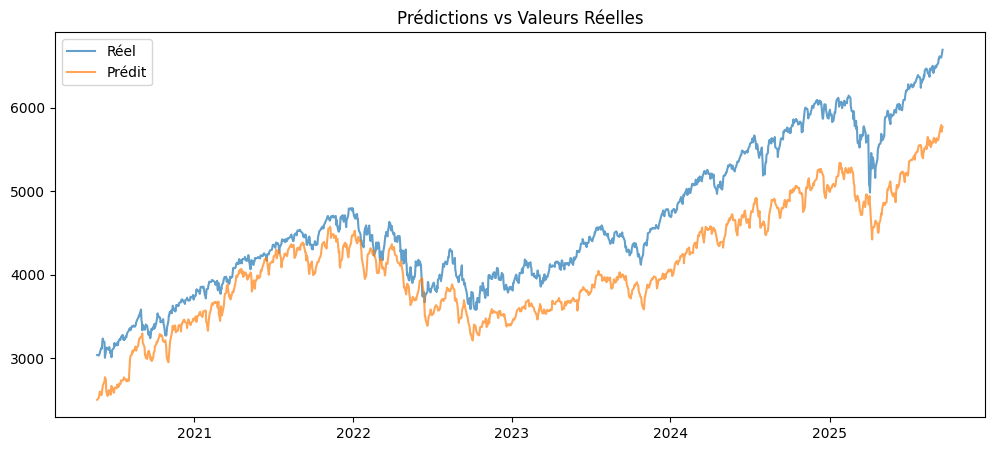

In [7]:
# Dénormaliser les prédictions
cible_idx = df.columns.get_loc('cible')
pred_denorm = scaler.inverse_transform(np.concatenate([np.zeros((len(predictions), cible_idx)), 
                                                        predictions, 
                                                        np.zeros((len(predictions), df.shape[1]-cible_idx-1))], axis=1))[:, cible_idx]
y_test_denorm = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), cible_idx)), 
                                                          y_test.reshape(-1,1), 
                                                          np.zeros((len(y_test), df.shape[1]-cible_idx-1))], axis=1))[:, cible_idx]

# Évaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print(f"MSE: {mean_squared_error(y_test_denorm, pred_denorm):.4f}")
print(f"MAE: {mean_absolute_error(y_test_denorm, pred_denorm):.4f}")
print(f"R²: {r2_score(y_test_denorm, pred_denorm):.4f}")

# Prédire le prochain point (future)
derniere_seq = data[-seq_len:].reshape(1, seq_len, df.shape[1])
next_pred = model.predict(derniere_seq)
next_pred_denorm = scaler.inverse_transform(np.concatenate([np.zeros((1, cible_idx)), 
                                                             next_pred, 
                                                             np.zeros((1, df.shape[1]-cible_idx-1))], axis=1))[0, cible_idx]
print(f"\nProchaine valeur prédite: {next_pred_denorm:.4f}")

# Visualisation (optionnel)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(df.iloc[-len(y_test_denorm):].index, y_test_denorm, label='Réel', alpha=0.7)
plt.plot(df.iloc[-len(y_test_denorm):].index, pred_denorm, label='Prédit', alpha=0.7)
plt.legend()
plt.title('Prédictions vs Valeurs Réelles')
plt.show()

In [63]:
results = pd.concat([pd.DataFrame(df.iloc[-len(y_test_denorm):].index, columns = ['date']), pd.DataFrame(pred_denorm, columns = ['pred']), pd.DataFrame(y_test_denorm, columns = ['real'])], axis=1)
results['diff'] = results['real'] - results['pred']
results

,date,pred,real,diff
0,2020-05-22,3014.606629,3036.13,21.523371
1,2020-05-26,3042.891180,3029.73,-13.161180
2,2020-05-27,3043.421630,3044.31,0.888370
3,2020-05-28,3042.488232,3055.73,13.241768
4,2020-05-29,3034.852842,3080.82,45.967158
...,...,...,...,...
1333,2025-09-12,6652.890313,6606.76,-46.130313
1334,2025-09-15,6637.127459,6600.35,-36.777459
1335,2025-09-16,6667.818221,6631.96,-35.858221
1336,2025-09-17,6752.137479,6664.36,-87.777479


In [ ]:
import random
import numpy as np
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# --- Générer un seed aléatoire pour cette exécution ---
seed = int(time.time()) % 2**32
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
print(f"Seed utilisé pour cette exécution : {seed}")

# --- Préparer les données ---
df = dataa.copy()
scaler = MinMaxScaler()
data = scaler.fit_transform(df)

# --- Hyperparamètres à tester ---
seq_lens = [10, 15, 30]
units_list = [50, 100]
batch_sizes = [16, 32]
learning_rates = 0.001

# --- EarlyStopping commun ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,
    verbose=0,
    restore_best_weights=True
)

# --- Suivi du meilleur modèle ---
best_val_loss = float('inf')
best_model_params = {}

# --- Boucle sur tous les hyperparamètres ---
for seq_len in seq_lens:
    # Création des séquences
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, df.columns.get_loc('cible')])
    X, y = np.array(X), np.array(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    for units in units_list:
        for batch_size in batch_sizes:
            lr = learning_rates
            # Réinitialiser le seed pour chaque combinaison
            random.seed(seed)
            np.random.seed(seed)
            tf.random.set_seed(seed)
            
            # Créer le modèle
            model = Sequential([
                LSTM(units, activation='relu', input_shape=(seq_len, df.shape[1])),
                Dense(1)
            ])
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
            
            # Entraîner
            history = model.fit(
                X_train, y_train,
                epochs=200,
                batch_size=batch_size,
                validation_data=(X_test, y_test),
                verbose=0,
                callbacks=[early_stop]
            )
            
            val_loss = min(history.history['val_loss'])
            print(f"seq_len={seq_len}, units={units}, batch_size={batch_size}, lr={lr}, val_loss={val_loss:.6f}")
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_params = {
                    'seq_len': seq_len,
                    'units': units,
                    'batch_size': batch_size,
                    'learning_rate': lr,
                    'seed': seed,
                    'model': model
                }

print("\nMeilleur modèle trouvé :")
print(best_model_params)
print(f"Validation Loss : {best_val_loss:.6f}")

# --- Pour reproduire ce modèle ---
best_seq_len = best_model_params['seq_len']
best_units = best_model_params['units']
best_batch_size = best_model_params['batch_size']
best_lr = best_model_params['learning_rate']
best_seed = best_model_params['seed']
best_model = best_model_params['model']

print(f"\nReproduire ce run avec seed : {best_seed} et seq_len : {best_seq_len}")


In [114]:
ser = """
seq_len=5, units=32, batch_size=16, lr=0.001, val_loss=0.000343
seq_len=5, units=32, batch_size=16, lr=0.0005, val_loss=0.002382
seq_len=5, units=32, batch_size=32, lr=0.001, val_loss=0.001041
seq_len=5, units=32, batch_size=32, lr=0.0005, val_loss=0.004187
seq_len=5, units=32, batch_size=64, lr=0.001, val_loss=0.001343
seq_len=5, units=32, batch_size=64, lr=0.0005, val_loss=0.001587
seq_len=5, units=50, batch_size=16, lr=0.001, val_loss=0.000154
seq_len=5, units=50, batch_size=16, lr=0.0005, val_loss=0.000674
seq_len=5, units=50, batch_size=32, lr=0.001, val_loss=0.000236
seq_len=5, units=50, batch_size=32, lr=0.0005, val_loss=0.001368
seq_len=5, units=50, batch_size=64, lr=0.001, val_loss=0.001290
seq_len=5, units=50, batch_size=64, lr=0.0005, val_loss=0.001832
seq_len=5, units=100, batch_size=16, lr=0.001, val_loss=0.000241
seq_len=5, units=100, batch_size=16, lr=0.0005, val_loss=0.000198
seq_len=5, units=100, batch_size=32, lr=0.001, val_loss=0.000174
seq_len=5, units=100, batch_size=32, lr=0.0005, val_loss=0.000415
seq_len=5, units=100, batch_size=64, lr=0.001, val_loss=0.000212
seq_len=5, units=100, batch_size=64, lr=0.0005, val_loss=0.000724
seq_len=10, units=32, batch_size=16, lr=0.001, val_loss=0.000200
seq_len=10, units=32, batch_size=16, lr=0.0005, val_loss=0.000274
seq_len=10, units=32, batch_size=32, lr=0.001, val_loss=0.001671
seq_len=10, units=32, batch_size=32, lr=0.0005, val_loss=0.001777
seq_len=10, units=32, batch_size=64, lr=0.001, val_loss=0.001473
seq_len=10, units=32, batch_size=64, lr=0.0005, val_loss=0.002099
seq_len=10, units=50, batch_size=16, lr=0.001, val_loss=0.000159
seq_len=10, units=50, batch_size=16, lr=0.0005, val_loss=0.000460
seq_len=10, units=50, batch_size=32, lr=0.001, val_loss=0.001759
seq_len=10, units=50, batch_size=32, lr=0.0005, val_loss=0.000735
seq_len=10, units=50, batch_size=64, lr=0.001, val_loss=0.000561
seq_len=10, units=50, batch_size=64, lr=0.0005, val_loss=0.000742
seq_len=10, units=100, batch_size=16, lr=0.001, val_loss=0.000237
seq_len=10, units=100, batch_size=16, lr=0.0005, val_loss=0.000237
seq_len=10, units=100, batch_size=32, lr=0.001, val_loss=0.000230
seq_len=10, units=100, batch_size=32, lr=0.0005, val_loss=0.003050
seq_len=10, units=100, batch_size=64, lr=0.001, val_loss=0.001533
seq_len=10, units=100, batch_size=64, lr=0.0005, val_loss=0.000363
seq_len=15, units=32, batch_size=16, lr=0.001, val_loss=0.000253
seq_len=15, units=32, batch_size=16, lr=0.0005, val_loss=0.000674
seq_len=15, units=32, batch_size=32, lr=0.001, val_loss=0.000427
seq_len=15, units=32, batch_size=32, lr=0.0005, val_loss=0.001324
seq_len=15, units=32, batch_size=64, lr=0.001, val_loss=0.001082
seq_len=15, units=32, batch_size=64, lr=0.0005, val_loss=0.001493
seq_len=15, units=50, batch_size=16, lr=0.001, val_loss=0.000122
seq_len=15, units=50, batch_size=16, lr=0.0005, val_loss=0.000261
seq_len=15, units=50, batch_size=32, lr=0.001, val_loss=0.000273
seq_len=15, units=50, batch_size=32, lr=0.0005, val_loss=0.001535
seq_len=15, units=50, batch_size=64, lr=0.001, val_loss=0.000829
seq_len=15, units=50, batch_size=64, lr=0.0005, val_loss=0.002551
seq_len=15, units=100, batch_size=16, lr=0.001, val_loss=0.000183
seq_len=15, units=100, batch_size=16, lr=0.0005, val_loss=0.000247
seq_len=15, units=100, batch_size=32, lr=0.001, val_loss=0.000331
seq_len=15, units=100, batch_size=32, lr=0.0005, val_loss=0.000600
seq_len=15, units=100, batch_size=64, lr=0.001, val_loss=0.000793
seq_len=15, units=100, batch_size=64, lr=0.0005, val_loss=0.000892
seq_len=20, units=32, batch_size=16, lr=0.001, val_loss=0.000608
seq_len=20, units=32, batch_size=16, lr=0.0005, val_loss=0.000315
seq_len=20, units=32, batch_size=32, lr=0.001, val_loss=0.000399
seq_len=20, units=32, batch_size=32, lr=0.0005, val_loss=0.001801
seq_len=20, units=32, batch_size=64, lr=0.001, val_loss=0.001289
seq_len=20, units=32, batch_size=64, lr=0.0005, val_loss=0.001740
seq_len=20, units=50, batch_size=16, lr=0.001, val_loss=0.000227
seq_len=20, units=50, batch_size=16, lr=0.0005, val_loss=0.001702
seq_len=20, units=50, batch_size=32, lr=0.001, val_loss=0.000700
seq_len=20, units=50, batch_size=32, lr=0.0005, val_loss=0.002068
seq_len=20, units=50, batch_size=64, lr=0.001, val_loss=0.001321
seq_len=20, units=50, batch_size=64, lr=0.0005, val_loss=0.001295
seq_len=20, units=100, batch_size=16, lr=0.001, val_loss=0.000265
seq_len=20, units=100, batch_size=16, lr=0.0005, val_loss=0.000261
seq_len=20, units=100, batch_size=32, lr=0.001, val_loss=0.000306
seq_len=20, units=100, batch_size=32, lr=0.0005, val_loss=0.001122
seq_len=20, units=100, batch_size=64, lr=0.001, val_loss=0.002296
seq_len=20, units=100, batch_size=64, lr=0.0005, val_loss=0.001424
seq_len=30, units=32, batch_size=16, lr=0.001, val_loss=0.000589
seq_len=30, units=32, batch_size=16, lr=0.0005, val_loss=0.000736
seq_len=30, units=32, batch_size=32, lr=0.001, val_loss=0.001370
seq_len=30, units=32, batch_size=32, lr=0.0005, val_loss=0.000795
seq_len=30, units=32, batch_size=64, lr=0.001, val_loss=0.000547
seq_len=30, units=32, batch_size=64, lr=0.0005, val_loss=0.001863
seq_len=30, units=50, batch_size=16, lr=0.001, val_loss=0.000118
seq_len=30, units=50, batch_size=16, lr=0.0005, val_loss=0.000600
seq_len=30, units=50, batch_size=32, lr=0.001, val_loss=0.001509
seq_len=30, units=50, batch_size=32, lr=0.0005, val_loss=0.001933
seq_len=30, units=50, batch_size=64, lr=0.001, val_loss=0.000827
seq_len=30, units=50, batch_size=64, lr=0.0005, val_loss=0.000723
seq_len=30, units=100, batch_size=16, lr=0.001, val_loss=0.000140
seq_len=30, units=100, batch_size=16, lr=0.0005, val_loss=0.000175
seq_len=30, units=100, batch_size=32, lr=0.001, val_loss=0.000110
seq_len=30, units=100, batch_size=32, lr=0.0005, val_loss=0.000420
seq_len=30, units=100, batch_size=64, lr=0.001, val_loss=0.002057
seq_len=30, units=100, batch_size=64, lr=0.0005, val_loss=0.000595
    """

import pandas as pd
import io

# On enlève les espaces et on remplace les virgules par des séparateurs
cleaned = ser.strip().replace(", ", ",")

# On sépare chaque ligne en dictionnaire clé=valeur
data = []
for line in cleaned.split("\n"):
    if not line.strip() or line.strip().startswith("#"):
        continue
    items = dict(item.split("=") for item in line.split(","))
    data.append(items)

# Conversion en DataFrame
df = pd.DataFrame(data)

# Conversion des colonnes numériques
df = df.astype({
    'seq_len': int,
    'units': int,
    'batch_size': int,
    'lr': float,
    'val_loss': float
})

df.sort_values('val_loss').head(20)


,seq_len,units,batch_size,lr,val_loss
86,30,100,32,0.0010,0.000110
78,30,50,16,0.0010,0.000118
42,15,50,16,0.0010,0.000122
84,30,100,16,0.0010,0.000140
6,5,50,16,0.0010,0.000154
24,10,50,16,0.0010,0.000159
14,5,100,32,0.0010,0.000174
85,30,100,16,0.0005,0.000175
48,15,100,16,0.0010,0.000183
13,5,100,16,0.0005,0.000198


In [62]:
import os, random, time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# ======================
# 1. Fixer la graine
# ======================
seed = 1759608945
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

print(f"Seed utilisé : {seed}")

# ======================
# 2. Préparer les données
# ======================
df = dataa.copy()  # Ton DataFrame initial avec 'cible'
# df['cible'] = df['cible'].shift(2)
# df.dropna(inplace=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

target_idx = df.columns.get_loc('cible')
n_features = df.shape[1]

# Split 80/20
train_size = int(len(df) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]
# n_features = X_train.shape[2] #train_data.shape[1]#df.shape[1]

# ======================
# 3. Fonctions utilitaires
# ======================
def create_sequences(data, seq_len, target_col_idx):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_col_idx])
    return np.array(X), np.array(y)

def build_model(seq_len, n_features, units, lr):
    model = Sequential([
        LSTM(units, activation='relu', input_shape=(seq_len, n_features)),
        # Dropout(0.2),
        # LSTM(units // 2, activation='relu', return_sequences=False),
        # Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

def build_model(seq_len, n_features, units, lr):
    model = Sequential([
        LSTM(units, activation='relu', return_sequences=True, input_shape=(seq_len, n_features)),
        Dropout(0.2),
        LSTM(units // 2, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

def build_model(seq_len, n_features, units, lr, n_layers=1):
    model = Sequential()
    for i in range(n_layers):
        return_seq = True if i < n_layers - 1 else False
        lstm_units = units // (2**i)
        if i == 0:
            model.add(LSTM(lstm_units, activation='relu', return_sequences=return_seq,
                           input_shape=(seq_len, n_features)))
        else:
            model.add(LSTM(lstm_units, activation='relu', return_sequences=return_seq))
        model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model


def find_best_hyperparams(train_data, seq_lens, units_list, batch_sizes, lr, epochs, target_idx, layer_options, n_features):
    """Teste toutes les combinaisons et retourne les meilleurs hyperparamètres (min val_loss)."""
    best_val_loss = float('inf')
    best_params = None
    early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
    for n_layers in layer_options:
        for seq_len in seq_lens:
            X_train, y_train = create_sequences(train_data, seq_len, target_idx)
            if len(X_train) < 10:
                continue
            for units in units_list:
                for batch_size in batch_sizes:
                    model = build_model(seq_len, n_features, units, lr)
                    history = model.fit(
                        X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.2,
                        verbose=1,
                        callbacks=[early_stop]
                    )
                    val_loss = min(history.history['val_loss'])
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_params = (seq_len, units, batch_size, n_layers)
    return best_params, best_val_loss

# ======================
# 4. Paramètres
# ======================
seq_lens = [10, 30]
units_list = [50, 100, 200]
batch_sizes = [16, 32] #max(8, len(X_train) // 50) #
layer_options = [1, 2, 3]
learning_rate = 0.001
epochs = 500
block_size = 250  

# ======================
# 5. Entraînement initial
# ======================
print("\n🔹 Recherche initiale des meilleurs hyperparamètres sur les 80% d'entraînement")

best_params, best_val_loss = find_best_hyperparams(
    train_data, seq_lens, units_list, batch_sizes,
    learning_rate, epochs, target_idx, layer_options, n_features
)
seq_len, units, batch_size, n_layers = best_params
print(f"Paramètres initiaux : seq_len={seq_len}, units={units}, batch={batch_size} (val_loss={best_val_loss:.5f})")

X_train, y_train = create_sequences(train_data, seq_len, target_idx)
model = build_model(seq_len, n_features, units, learning_rate, n_layers=n_layers)
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.2,
          callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)])

# ======================
# 6. Boucle de mise à jour et prédiction progressive
# ======================
print("\n🔹 Début des prédictions progressives sur les 20% restants")

predictions_df = pd.DataFrame(index=df.index, columns=['prediction', 'cible'])
n_test = len(test_data)

# On parcourt la totalité du test, même s’il reste un dernier bloc plus petit
for step_start in range(0, n_test, block_size):
    step_end = min(step_start + block_size, n_test)
    print(f"\n📦 Bloc {step_start} → {step_end} ({step_end - step_start} lignes)")

    # Préparation du bloc test
    X_test, y_test = create_sequences(test_data[step_start:step_end + seq_len], seq_len, target_idx)
    if len(X_test) == 0:
        continue

    # --- Prédiction sur le bloc ---
    preds_scaled = model.predict(X_test, verbose=0).flatten()
    preds_full = np.zeros((len(preds_scaled), scaled_data.shape[1]))
    preds_full[:, target_idx] = preds_scaled
    preds_real = scaler.inverse_transform(preds_full)[:, target_idx]

    global_idx = df.index[train_size + step_start + seq_len : train_size + step_start + seq_len + len(preds_real)]
    predictions_df.loc[global_idx, 'prediction'] = preds_real
    predictions_df.loc[global_idx, 'cible'] = df.loc[global_idx, 'cible'].values

    # --- Mise à jour du train_data ---
    train_data = np.concatenate([
        train_data[block_size:] if len(train_data) > block_size else train_data,
        test_data[step_start:step_end]
    ])

    if (step_end - step_start) == block_size:
        # --- Nouvelle recherche d’hyperparamètres ---
        # best_params, best_val_loss = find_best_hyperparams(
        #     train_data, seq_lens, units_list, batch_sizes,
        #     learning_rate, epochs, target_idx, n_features
        # )
        # seq_len, units, batch_size = best_params
        # print(f"🔁 Nouveaux meilleurs paramètres : seq_len={seq_len}, units={units}, batch={batch_size} (val_loss={best_val_loss:.5f})")

        # --- Réentraînement du modèle mis à jour ---
    
        X_train, y_train = create_sequences(train_data, seq_len, target_idx)
        # model = build_model(seq_len, n_features, units, learning_rate)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.2,
                callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)])

# ======================
# 7. Résultat final
# ======================
print("\nSimulation terminée ✅")
print(predictions_df.dropna().head())
# predictions_df.to_csv('pred_lstm_syl2.csv', sep='|')


Seed utilisé : 1759608945

🔹 Recherche initiale des meilleurs hyperparamètres sur les 80% d'entraînement
Epoch 1/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0084 - val_loss: 0.0013
Epoch 2/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.2304e-04 - val_loss: 4.1605e-04
Epoch 3/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.7138e-04 - val_loss: 7.0857e-04
Epoch 4/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3048e-04 - val_loss: 6.2123e-04
Epoch 5/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0313e-04 - val_loss: 4.0750e-04
Epoch 6/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6704e-04 - val_loss: 6.7240e-04
Epoch 7/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4254e-04 - val_loss: 8.2365e-04
Epoch 8/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3642e-04 - val_loss: 5.2396e-04
Epoch 9/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2822e-04 - val_loss: 0.0011
Epoch 10/500
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste

In [ ]:
print(best_params)

In [10]:
##################
#   DERNIER RETENUS
##################

import os, random, time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# ======================
# 1. Fixer la graine
# ======================
seed = 1759608945
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

print(f"Seed utilisé : {seed}")

# ======================
# 2. Préparer les données
# ======================
df = dataa.copy()  # Ton DataFrame initial avec 'cible'
# df['cible'] = df['cible'].shift(2)
# df.dropna(inplace=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

target_idx = df.columns.get_loc('cible')
n_features = df.shape[1]

# Split 80/20
train_size = int(len(df) *0.8991)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]
# n_features = X_train.shape[2] #train_data.shape[1]#df.shape[1]

# ======================
# 3. Fonctions utilitaires
# ======================
def create_sequences(data, seq_len, target_col_idx):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_col_idx])
    return np.array(X), np.array(y)

def build_model(seq_len, n_features, units, lr, n_layers=1):
    model = Sequential()
    for i in range(n_layers):
        return_seq = True if i < n_layers - 1 else False
        lstm_units = units // (2**i)
        if i == 0:
            model.add(LSTM(lstm_units, activation='relu', return_sequences=return_seq,
                           input_shape=(seq_len, n_features)))
        else:
            model.add(LSTM(lstm_units, activation='relu', return_sequences=return_seq))
        model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

def find_best_hyperparams(train_data, seq_lens, units_list, batch_sizes, lr, epochs, target_idx, layer_options, n_features):
    """Teste toutes les combinaisons et retourne les meilleurs hyperparamètres (min val_loss)."""
    best_val_loss = float('inf')
    best_params = None
    early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
    for n_layers in layer_options:
        for seq_len in seq_lens:
            X_train, y_train = create_sequences(train_data, seq_len, target_idx)
            if len(X_train) < 10:
                continue
            for units in units_list:
                for batch_size in batch_sizes:
                    model = build_model(seq_len, n_features, units, lr)
                    history = model.fit(
                        X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=validation_split,
                        verbose=1,
                        callbacks=[early_stop]
                    )
                    val_loss = min(history.history['val_loss'])
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_params = (seq_len, units, batch_size, n_layers)
    return best_params, best_val_loss

# ======================
# 4. Paramètres
# ======================
seq_lens = 15
units_list = 50
batch_sizes = 32 #max(8, len(X_train) // 50)
layer_options = 1
learning_rate = 0.001
epochs = 500
block_size = 250  
patience = 50
validation_split = 0.05


# ======================
# 5. Entraînement initial
# ======================
print("\n🔹 Recherche initiale des meilleurs hyperparamètres sur les 80% d'entraînement")

# best_params, best_val_loss = find_best_hyperparams(
#     train_data, seq_lens, units_list, batch_sizes,
#     learning_rate, epochs, target_idx, layer_options, n_features
# )
best_params = (seq_lens, units_list, batch_sizes, layer_options)

seq_len, units, batch_size, n_layers = best_params
print(f"Paramètres initiaux : seq_len={seq_len}, units={units}, batch={batch_size}")

X_train, y_train = create_sequences(train_data, seq_len, target_idx)
split_idx = int(len(X_train)*0.9)
X_val, y_val = X_train[split_idx:], y_train[split_idx:]
X_train, y_train = X_train[:split_idx], y_train[:split_idx]
model = build_model(seq_len, n_features, units, learning_rate, n_layers=n_layers)
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), 
          callbacks=[EarlyStopping(monitor='val_loss', patience=patience, verbose = 1, restore_best_weights=True)])

# ======================
# 6. Boucle de mise à jour et prédiction progressive
# ======================
print("\n🔹 Début des prédictions progressives sur les 20% restants")

predictions_df = pd.DataFrame(index=df.index, columns=['prediction', 'cible'])
n_test = len(test_data)

# On parcourt la totalité du test, même s’il reste un dernier bloc plus petit
for step_start in range(0, n_test, block_size):
    step_end = min(step_start + block_size, n_test)
    print(f"\n📦 Bloc {step_start} → {step_end} ({step_end - step_start} lignes)")

    # Préparation du bloc test
    X_test, y_test = create_sequences(test_data[step_start:step_end + seq_len], seq_len, target_idx)
    if len(X_test) == 0:
        continue

    # --- Prédiction sur le bloc ---
    preds_scaled = model.predict(X_test, verbose=0).flatten()
    preds_full = np.zeros((len(preds_scaled), scaled_data.shape[1]))
    preds_full[:, target_idx] = preds_scaled
    preds_real = scaler.inverse_transform(preds_full)[:, target_idx]

    global_idx = df.index[train_size + step_start + seq_len : train_size + step_start + seq_len + len(preds_real)]
    predictions_df.loc[global_idx, 'prediction'] = preds_real
    predictions_df.loc[global_idx, 'cible'] = df.loc[global_idx, 'cible'].values

    # --- Mise à jour du train_data ---
    train_data = np.concatenate([
        train_data[block_size:] if len(train_data) > block_size else train_data,
        test_data[step_start:step_end]
    ])

    if (step_end - step_start) == block_size:
        # --- Nouvelle recherche d’hyperparamètres ---
        # best_params, best_val_loss = find_best_hyperparams(
        #     train_data, seq_lens, units_list, batch_sizes,
        #     learning_rate, epochs, target_idx, n_features
        # )
        # seq_len, units, batch_size = best_params
        # print(f"🔁 Nouveaux meilleurs paramètres : seq_len={seq_len}, units={units}, batch={batch_size} (val_loss={best_val_loss:.5f})")

        # --- Réentraînement du modèle mis à jour ---
    
        X_train, y_train = create_sequences(train_data, seq_len, target_idx)
        # model = build_model(seq_len, n_features, units, learning_rate)
        split_idx = int(len(X_train)*0.9)
        X_val, y_val = X_train[split_idx:], y_train[split_idx:]
        X_train, y_train = X_train[:split_idx], y_train[:split_idx]
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val),
                callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])

# ======================
# 7. Résultat final
# ======================
print("\nSimulation terminée ✅")
print(predictions_df.dropna().head())
# predictions_df.to_csv('pred_lstm_syl2.csv', sep='|')


Seed utilisé : 1759608945

🔹 Recherche initiale des meilleurs hyperparamètres sur les 80% d'entraînement
Paramètres initiaux : seq_len=15, units=50, batch=32
Epoch 1/500
170/170 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0111 - val_loss: 0.0017
Epoch 2/500
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010 - val_loss: 0.0040
Epoch 3/500
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.4708e-04 - val_loss: 7.0338e-04
Epoch 4/500
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.8487e-04 - val_loss: 0.0013
Epoch 5/500
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.5987e-04 - val_loss: 0.0013
Epoch 6/500
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.8761e-04 - val_loss: 0.0038
Epoch 7/500
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.9316e-04 - val_loss: 0.0098
Epoch 8/500
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.6456e-04 - val_loss: 0.0055
Epoch 9/500
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.5253e-04 - val_loss: 0.0024
Epoch 10/500
170/170 ━━━━━━

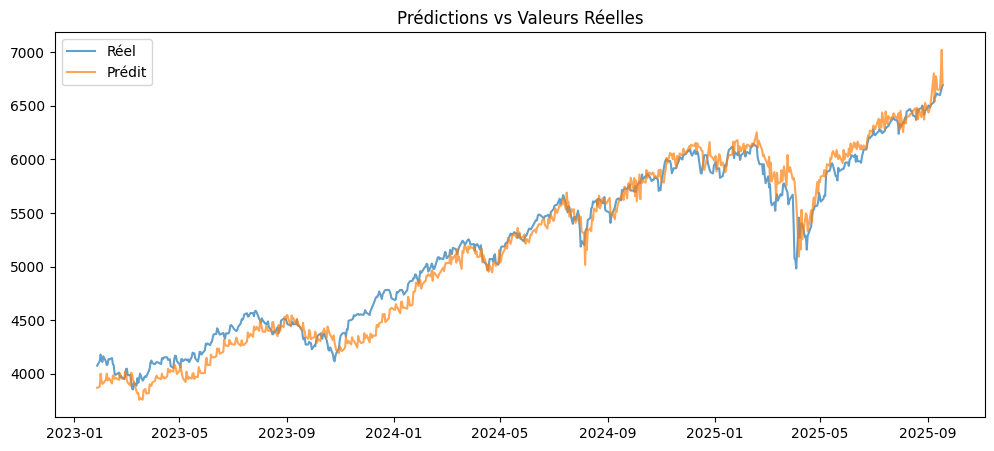

In [ ]:
# pas mal : Paramètres initiaux : seq_len=15, units=100, batch=32, epochs = 500, block_size = 1000  patience = 50, validation_split = 0.05 (sans shuffle)
# pas mal : Paramètres initiaux : seq_len=15, units=100, batch=32, epochs = 500, block_size = 250  patience = 100, validation_ (val data)
# pas mal : Paramètres initiaux : seq_len=15, units=50, batch=32, epochs = 500, block_size = 250  patience = 100, validation_ (val data)
dd = predictions_df.copy()
plt.figure(figsize=(12,5))
plt.plot(dd.index, dd['cible'], label='Réel', alpha=0.7)
plt.plot(dd.index, dd['prediction'], label='Prédit', alpha=0.7)
plt.legend()
plt.title('Prédictions vs Valeurs Réelles')
plt.show()

45 minutes
Paramètres initiaux : seq_len=30, units=200, batch=16 (val_loss=0.00013)

🔹 Début des prédictions progressives sur les 20% restants

📦 Bloc 0 → 250 (250 lignes)

📦 Bloc 250 → 500 (250 lignes)

📦 Bloc 500 → 750 (250 lignes)

📦 Bloc 750 → 1000 (250 lignes)

📦 Bloc 1000 → 1250 (250 lignes)

📦 Bloc 1250 → 1344 (94 lignes)

Simulation terminée ✅
             prediction    cible
date                            
2020-06-26  2967.875414  3100.29
2020-06-29  2953.732421  3115.86
2020-06-30  2967.951628  3130.01
2020-07-01   2969.62475  3179.72
2020-07-02  2982.356976  3145.32

best_params (30, 200, 16, 1)

In [ ]:
import os, random, time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# ======================
# 1. Fixer la graine
# ======================
seed = 1759608945
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

print(f"Seed utilisé : {seed}")

# ======================
# 2. Préparer les données
# ======================
df = dataa.copy()  # Ton DataFrame initial avec 'cible'
# df['cible'] = df['cible'].shift(2)
# df.dropna(inplace=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

target_idx = df.columns.get_loc('cible')
n_features = df.shape[1]

# Split 80/20
train_size = int(len(df) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]
# n_features = X_train.shape[2] #train_data.shape[1]#df.shape[1]

# ======================
# 3. Fonctions utilitaires
# ======================
def create_sequences(data, seq_len, target_col_idx):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_col_idx])
    return np.array(X), np.array(y)

def build_model(seq_len, n_features, units, lr):
    model = Sequential([
        LSTM(units, activation='relu', input_shape=(seq_len, n_features)),
        # Dropout(0.2),
        # LSTM(units // 2, activation='relu', return_sequences=False),
        # Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

def build_model(seq_len, n_features, units, lr):
    model = Sequential([
        LSTM(units, activation='relu', return_sequences=True, input_shape=(seq_len, n_features)),
        Dropout(0.2),
        LSTM(units // 2, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

def build_model(seq_len, n_features, units, lr, n_layers=1):
    model = Sequential()
    for i in range(n_layers):
        return_seq = True if i < n_layers - 1 else False
        lstm_units = units // (2**i)
        if i == 0:
            model.add(LSTM(lstm_units, activation='relu', return_sequences=return_seq,
                           input_shape=(seq_len, n_features)))
        else:
            model.add(LSTM(lstm_units, activation='relu', return_sequences=return_seq))
        model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model


def find_best_hyperparams(train_data, seq_lens, units_list, batch_sizes, lr, epochs, target_idx, layer_options, n_features):
    """Teste toutes les combinaisons et retourne les meilleurs hyperparamètres (min val_loss)."""
    best_val_loss = float('inf')
    best_params = None
    early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
    for n_layers in layer_options:
        for seq_len in seq_lens:
            X_train, y_train = create_sequences(train_data, seq_len, target_idx)
            if len(X_train) < 10:
                continue
            for units in units_list:
                for batch_size in batch_sizes:
                    model = build_model(seq_len, n_features, units, lr)
                    history = model.fit(
                        X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=validation_split,
                        verbose=1,
                        callbacks=[early_stop]
                    )
                    val_loss = min(history.history['val_loss'])
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_params = (seq_len, units, batch_size, n_layers)
    return best_params, best_val_loss

# ======================
# 4. Paramètres
# ======================
seq_lens = [10, 30]
units_list = [50, 100, 200]
batch_sizes = [16, 32] #max(8, len(X_train) // 50)
layer_options = [1, 2, 3]
learning_rate = 0.001
epochs = 500
block_size = 250  

validation_split = 0.4

# ======================
# 5. Entraînement initial
# ======================
print("\n🔹 Recherche initiale des meilleurs hyperparamètres sur les 80% d'entraînement")

best_params, best_val_loss = find_best_hyperparams(
    train_data, seq_lens, units_list, batch_sizes,
    learning_rate, epochs, target_idx, layer_options, n_features
)
seq_len, units, batch_size, n_layers = best_params
print(f"Paramètres initiaux : seq_len={seq_len}, units={units}, batch={batch_size} (val_loss={best_val_loss:.5f})")

X_train, y_train = create_sequences(train_data, seq_len, target_idx)
model = build_model(seq_len, n_features, units, learning_rate, n_layers=n_layers)
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=0.2,
          callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)])

# ======================
# 6. Boucle de mise à jour et prédiction progressive
# ======================
print("\n🔹 Début des prédictions progressives sur les 20% restants")

predictions_df = pd.DataFrame(index=df.index, columns=['prediction', 'cible'])
n_test = len(test_data)

# On parcourt la totalité du test, même s’il reste un dernier bloc plus petit
for step_start in range(0, n_test, block_size):
    step_end = min(step_start + block_size, n_test)
    print(f"\n📦 Bloc {step_start} → {step_end} ({step_end - step_start} lignes)")

    # Préparation du bloc test
    X_test, y_test = create_sequences(test_data[step_start:step_end + seq_len], seq_len, target_idx)
    if len(X_test) == 0:
        continue

    # --- Prédiction sur le bloc ---
    preds_scaled = model.predict(X_test, verbose=0).flatten()
    preds_full = np.zeros((len(preds_scaled), scaled_data.shape[1]))
    preds_full[:, target_idx] = preds_scaled
    preds_real = scaler.inverse_transform(preds_full)[:, target_idx]

    global_idx = df.index[train_size + step_start + seq_len : train_size + step_start + seq_len + len(preds_real)]
    predictions_df.loc[global_idx, 'prediction'] = preds_real
    predictions_df.loc[global_idx, 'cible'] = df.loc[global_idx, 'cible'].values

    # --- Mise à jour du train_data ---
    train_data = np.concatenate([
        train_data[block_size:] if len(train_data) > block_size else train_data,
        test_data[step_start:step_end]
    ])

    if (step_end - step_start) == block_size:
        # --- Nouvelle recherche d’hyperparamètres ---
        # best_params, best_val_loss = find_best_hyperparams(
        #     train_data, seq_lens, units_list, batch_sizes,
        #     learning_rate, epochs, target_idx, n_features
        # )
        # seq_len, units, batch_size = best_params
        # print(f"🔁 Nouveaux meilleurs paramètres : seq_len={seq_len}, units={units}, batch={batch_size} (val_loss={best_val_loss:.5f})")

        # --- Réentraînement du modèle mis à jour ---
    
        X_train, y_train = create_sequences(train_data, seq_len, target_idx)
        # model = build_model(seq_len, n_features, units, learning_rate)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=validation_split,
                callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)])

# ======================
# 7. Résultat final
# ======================
print("\nSimulation terminée ✅")
print(predictions_df.dropna().head())
# predictions_df.to_csv('pred_lstm_syl2.csv', sep='|')


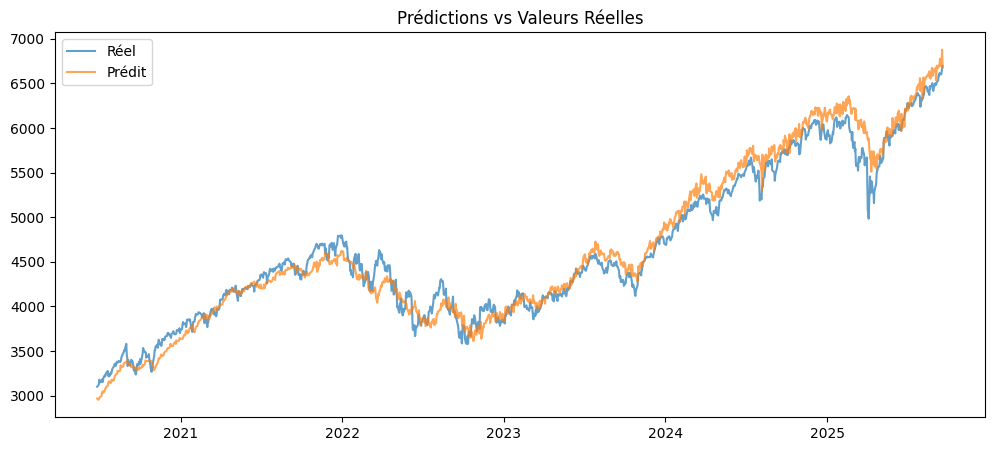

In [63]:
dd4 = predictions_df.copy()
plt.figure(figsize=(12,5))
plt.plot(dd4.index, dd4['cible'], label='Réel', alpha=0.7)
plt.plot(dd4.index, dd4['prediction'], label='Prédit', alpha=0.7)
plt.legend()
plt.title('Prédictions vs Valeurs Réelles')
plt.show()

In [45]:
print("X_train.shape:", X_train.shape)
print("n_features:", n_features)


X_train.shape: (5345, 30, 51)
n_features: 51


In [34]:
print(f"🔍 Shape X_train: {X_train.shape}, y_train: {y_train.shape}")
print("n_features =", n_features)

🔍 Shape X_train: (5345, 30, 51), y_train: (5345,)
n_features = 53


Seed utilisé : 1759608945

🔹 Recherche initiale des meilleurs hyperparamètres sur les 80% d'entraînement
Paramètres initiaux : seq_len=30, units=100, batch=32 (val_loss=0.00007)

🔹 Début des prédictions progressives sur les 20% restants

📦 Bloc 0 → 1000 (1000 lignes)
🔁 Nouveaux meilleurs paramètres : seq_len=30, units=200, batch=16 (val_loss=0.00021)

📦 Bloc 1000 → 1344 (344 lignes)

Simulation terminée ✅
             prediction    cible
date                            
2020-06-26  2891.269912  3100.29
2020-06-29  2859.269165  3115.86
2020-06-30  2877.330635  3130.01
2020-07-01  2893.893827  3179.72
2020-07-02   2936.83335  3145.32

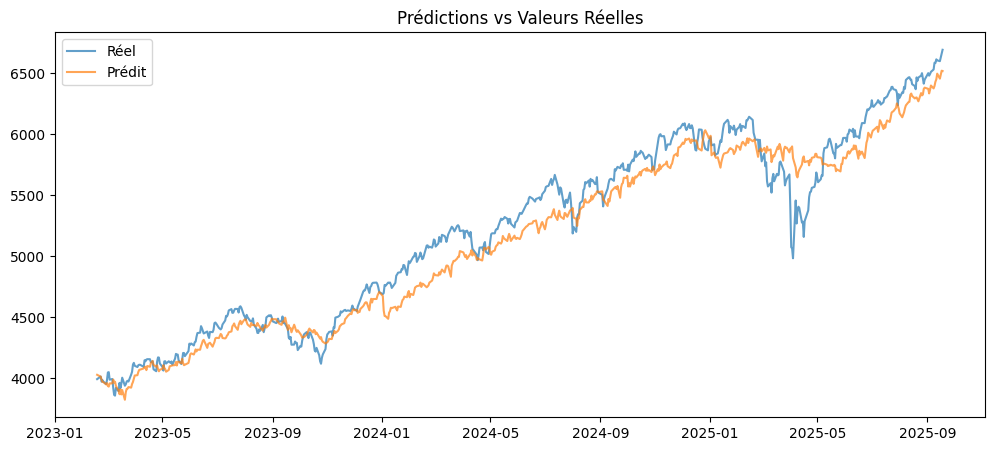

In [10]:
dd4 = predictions_df.copy()
plt.figure(figsize=(12,5))
plt.plot(dd4.index, dd4['cible'], label='Réel', alpha=0.7)
plt.plot(dd4.index, dd4['prediction'], label='Prédit', alpha=0.7)
plt.legend()
plt.title('Prédictions vs Valeurs Réelles')
plt.show()

In [161]:
# import os, random, time
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.optimizers import Adam
# from sklearn.preprocessing import MinMaxScaler

# # ======================
# # 1. Fixer la graine
# # ======================
# seed = 1759608945
# random.seed(seed)
# np.random.seed(seed)
# tf.random.set_seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)

# print(f"Seed utilisé : {seed}")

# # ======================
# # 2. Préparer les données
# # ======================
# df = dataa.copy()  # Ton DataFrame initial avec 'cible'
# df['cible'] = df['cible'].shift(2)
# df.dropna(inplace=True)

# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(df)

# target_idx = df.columns.get_loc('cible')
# n_features = df.shape[1]

# # Split 80/20
# train_size = int(len(df) * 0.8)
# train_data = scaled_data[:train_size]
# test_data = scaled_data[train_size:]

# # ======================
# # 3. Fonctions utilitaires
# # ======================
# def create_sequences(data, seq_len, target_col_idx, forecast_horizon: int = 2):
#     X, y = [], []
#     for i in range(len(data) - seq_len - forecast_horizon +1):
#         X.append(data[i:i+seq_len])
#         y.append(data[i+seq_len + fh -1, target_col_idx])
#     return np.array(X), np.array(y)

# def build_model(seq_len, n_features, units, lr):
#     model = Sequential([
#         LSTM(units, activation='relu', input_shape=(seq_len, n_features)),
#         Dense(fh)
#     ])
#     model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
#     return model

# def find_best_hyperparams(train_data, seq_lens, units_list, batch_sizes, lr, epochs, target_idx, n_features):
#     """Teste toutes les combinaisons et retourne les meilleurs hyperparamètres (min val_loss)."""
#     best_val_loss = float('inf')
#     best_params = None
#     early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=0, restore_best_weights=True)
    
#     for seq_len in seq_lens:
#         X_train, y_train = create_sequences(train_data, seq_len, target_idx)
#         if len(X_train) < 10:
#             continue
#         for units in units_list:
#             for batch_size in batch_sizes:
#                 model = build_model(seq_len, n_features, units, lr)
#                 history = model.fit(
#                     X_train, y_train,
#                     epochs=epochs,
#                     batch_size=batch_size,
#                     validation_split=0.2,
#                     verbose=0,
#                     callbacks=[early_stop]
#                 )
#                 val_loss = min(history.history['val_loss'])
#                 if val_loss < best_val_loss:
#                     best_val_loss = val_loss
#                     best_params = (seq_len, units, batch_size)
#     return best_params, best_val_loss

# # ======================
# # 4. Paramètres
# # ======================
# seq_lens = [10, 15, 30]
# units_list = [50, 100]
# batch_sizes = [16, 32]
# learning_rate = 0.001
# fh = 2 # forcast horizon
# epochs = 200
# block_size = 1000  # ⬅️ tu peux changer ici

# # ======================
# # 5. Entraînement initial
# # ======================
# print("\n🔹 Recherche initiale des meilleurs hyperparamètres sur les 80% d'entraînement")

# best_params, best_val_loss = find_best_hyperparams(
#     train_data, seq_lens, units_list, batch_sizes,
#     learning_rate, epochs, target_idx, n_features
# )
# seq_len, units, batch_size = best_params
# print(f"✅ Paramètres initiaux : seq_len={seq_len}, units={units}, batch={batch_size} (val_loss={best_val_loss:.5f})")

# X_train, y_train = create_sequences(train_data, seq_len, target_idx)
# model = build_model(seq_len, n_features, units, learning_rate)
# model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0,
#           callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

# # ======================
# # 6. Boucle de mise à jour et prédiction progressive
# # ======================
# print("\n🔹 Début des prédictions progressives sur les 20% restants")

# predictions_df = pd.DataFrame(index=df.index, columns=['prediction', 'cible'])
# n_test = len(test_data)

# # On parcourt la totalité du test, même s’il reste un dernier bloc plus petit
# for step_start in range(0, n_test, block_size):
#     step_end = min(step_start + block_size, n_test)
#     print(f"\n📦 Bloc {step_start} → {step_end} ({step_end - step_start} lignes)")

#     # Préparation du bloc test
#     X_test, y_test = create_sequences(test_data[step_start:step_end + seq_len], seq_len, target_idx)
#     if len(X_test) == 0:
#         continue

#     # --- Prédiction sur le bloc ---
#     preds_scaled = model.predict(X_test, verbose=0).flatten()
#     preds_full = np.zeros((len(preds_scaled), scaled_data.shape[1]))
#     preds_full[:, target_idx] = preds_scaled
#     preds_real = scaler.inverse_transform(preds_full)[:, target_idx]

#     global_idx = df.index[train_size + step_start + seq_len : train_size + step_start + seq_len + len(preds_real)]
#     predictions_df.loc[global_idx, 'prediction'] = preds_real
#     predictions_df.loc[global_idx, 'cible'] = df.loc[global_idx, 'cible'].values

#     # --- Mise à jour du train_data ---
#     train_data = np.concatenate([
#         train_data[block_size:] if len(train_data) > block_size else train_data,
#         test_data[step_start:step_end]
#     ])

#     # --- Nouvelle recherche d’hyperparamètres ---
#     best_params, best_val_loss = find_best_hyperparams(
#         train_data, seq_lens, units_list, batch_sizes,
#         learning_rate, epochs, target_idx, n_features
#     )
#     seq_len, units, batch_size = best_params
#     print(f"🔁 Nouveaux meilleurs paramètres : seq_len={seq_len}, units={units}, batch={batch_size} (val_loss={best_val_loss:.5f})")

#     # --- Réentraînement du modèle mis à jour ---
#     X_train, y_train = create_sequences(train_data, seq_len, target_idx)
#     model = build_model(seq_len, n_features, units, learning_rate)
#     model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0,
#               callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

# # ======================
# # 7. Résultat final
# # ======================
# print("\nSimulation terminée ✅")
# print(predictions_df.dropna().head())
# predictions_df.to_csv('pred_lstm_syl.csv', sep='|')


Seed utilisé : 1759608945

🔹 Recherche initiale des meilleurs hyperparamètres sur les 80% d'entraînement
✅ Paramètres initiaux : seq_len=15, units=100, batch=32 (val_loss=0.00009)

🔹 Début des prédictions progressives sur les 20% restants

📦 Bloc 0 → 500 (500 lignes)
🔁 Nouveaux meilleurs paramètres : seq_len=10, units=50, batch=32 (val_loss=0.00009)

📦 Bloc 500 → 1000 (500 lignes)
🔁 Nouveaux meilleurs paramètres : seq_len=10, units=50, batch=16 (val_loss=0.00013)

📦 Bloc 1000 → 1344 (344 lignes)
🔁 Nouveaux meilleurs paramètres : seq_len=30, units=100, batch=32 (val_loss=0.00017)

Simulation terminée ✅
             prediction    cible
date                            
2020-06-05  3165.629124  3207.18
2020-06-08  3134.333312  3190.14
2020-06-09  3139.092475   3002.1
2020-06-10    3013.9216  3041.31
2020-06-11  3023.106377  3066.59

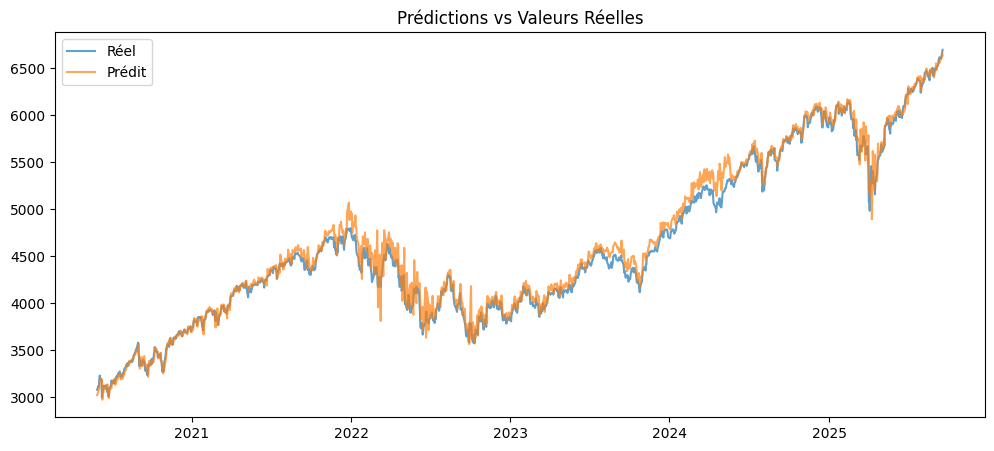

In [160]:
dd3 = predictions_df.copy()
plt.figure(figsize=(12,5))
plt.plot(dd3.index, dd3['cible'], label='Réel', alpha=0.7)
plt.plot(dd3.index, dd3['prediction'], label='Prédit', alpha=0.7)
plt.legend()
plt.title('Prédictions vs Valeurs Réelles')
plt.show()

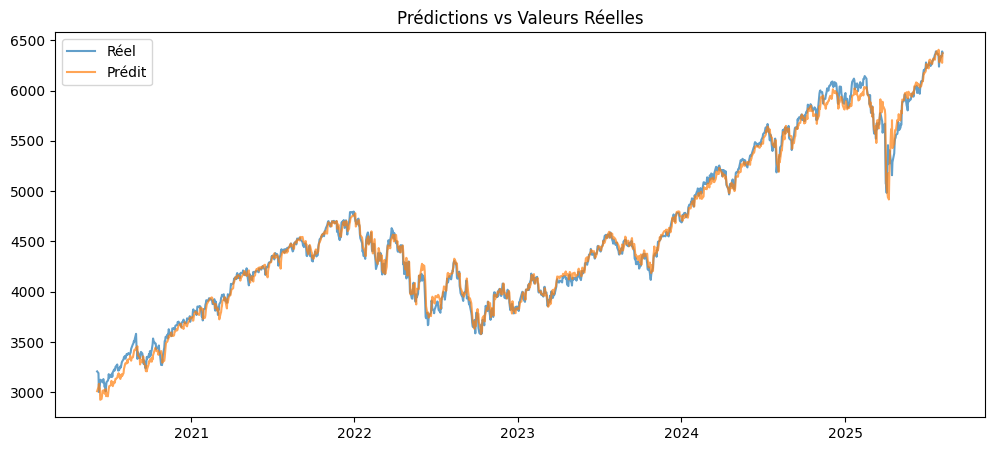

In [ ]:
# dd1 = dd.copy()
plt.figure(figsize=(12,5))
plt.plot(dd1.index, dd1['cible'], label='Réel', alpha=0.7)
plt.plot(dd1.index, dd1['prediction'], label='Prédit', alpha=0.7)
plt.legend()
plt.title('Prédictions vs Valeurs Réelles')
plt.show()

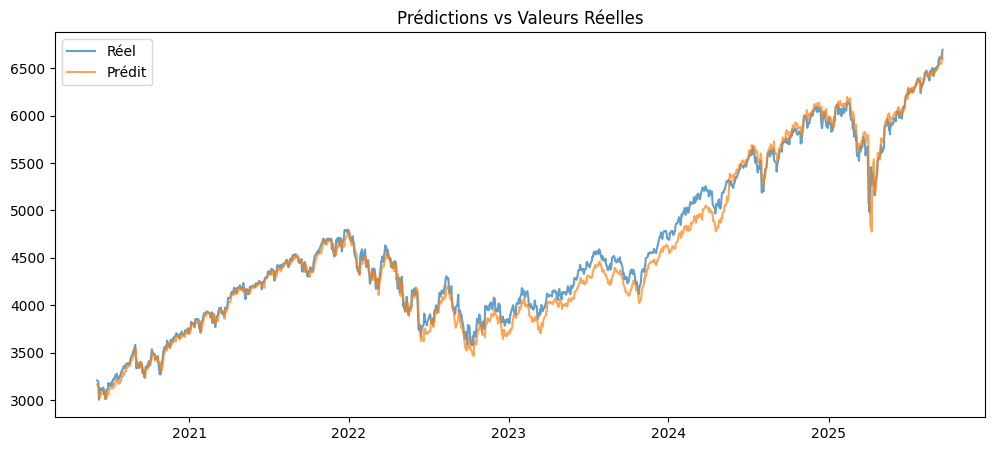

In [ ]:
# dd2 = predictions_df.copy()
plt.figure(figsize=(12,5))
plt.plot(dd2.index, dd2['cible'], label='Réel', alpha=0.7)
plt.plot(dd2.index, dd2['prediction'], label='Prédit', alpha=0.7)
plt.legend()
plt.title('Prédictions vs Valeurs Réelles')
plt.show()